# Santiago's pois time

This notebook loads specific points (already filtered and classified for a given source of interest) and a source_name, calculates and loads into database the time from each node in Santiago, Chile to its closest poi (Function analysis>pois_time())

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [2]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = False

##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [7]:
# Directory where pois to be examined are located
pois_dir = 'test'
# Name of pois to be examined (source_name)
source = 'test'

# Pois proximity methodology - Count pois at a given time proximity?
count_pois = (True,15)

# Save output
save_schema = 'projects_research'
nodes_save_table = 'nodesproximity_santiago'

## Required data for pois_time

#### Area of interest and OSMnx Network

In [3]:
# Area of interest
aoi_schema = 'projects_research'
aoi_table = 'santiago_aoi'
query = f"SELECT * FROM {aoi_schema}.{aoi_table}"
aoi = aup.gdf_from_query(query, geometry_col='geometry')
aoi = aoi.set_crs("EPSG:4326")

# OSMnx Network
network_schema = 'projects_research'
edges_table = 'santiago_edges'
nodes_table = 'santiago_nodes'
projected_crs = 'EPSG:32719'
G, nodes, edges = aup.graph_from_hippo(aoi, network_schema, edges_table, nodes_table, projected_crs)

<Axes: >

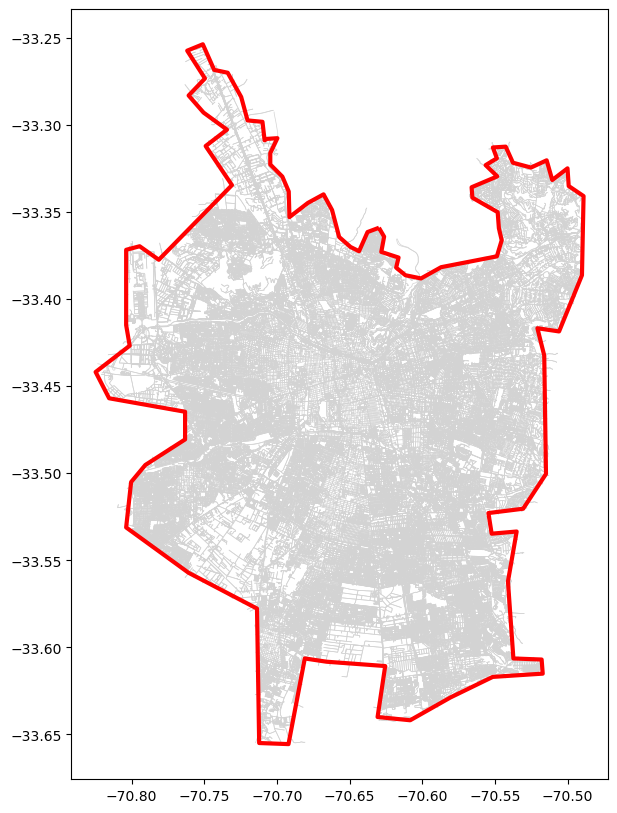

In [5]:
# Show
fig,ax = plt.subplots(figsize=(10,10))
edges.plot(ax=ax,zorder=1,linewidth=0.5,edgecolor='lightgray')
aoi.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=3)

#### Points of interest (pois)

In [ ]:
pois = gpd.read_file(pois_dir)
pois = pois[['code','geometry']]
pois = pois.set_crs("EPSG:4326")

######### DUDA: ¿Cortar los puntos para solo conservar los que hay dentro del aoi? ¿Establecer una max_distance?
aoi_pois = gpd.sjoin(pois, aoi)
pois = aoi_pois.copy()

# Show
print(pois.shape)
pois.head(2)

In [ ]:
# 2.3 --------------- SOURCE ANALYSIS
# Calculate time data from nodes to source
source_nodes_time = aup.pois_time(G, nodes, edges, source_pois, source, prox_measure='length', count_pois=count_pois)
source_nodes_time.rename(columns={'time_'+source:source},inplace=True)
nodes_analysis = source_nodes_time.copy()

# 2.4 --------------- OUTPUT MERGE
# Not needed if just running one source

# 2.5 --------------- Final format for nodes
# if count_pois, include generated col
if count_pois[0]:
    column_order = ['osmid'] + [source, f'{source}_{count_pois[1]}min'] + ['x','y','geometry']
else:
    column_order = ['osmid'] + [source] + ['x','y','geometry']
nodes_analysis = nodes_analysis[column_order]

# Show
print(nodes_analysis.shape)
nodes_analysis.head(2)

In [ ]:
if save:
    nodes_analysis['city'] = 'Santiago'
    aup.gdf_to_db_slow(nodes_analysis, nodes_save_table, save_schema, if_exists='append')